In [1]:
#pip install openpyxl

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn import svm
import openpyxl
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import xlsxwriter

In [3]:
train_df = pd.read_excel('Data_Train.xlsx')
test_df = pd.read_excel('Test_set.xlsx')

In [4]:
train_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [6]:
#Append train and test dataset for cleaning and transfromation
main_df=train_df.append(test_df)

/var/folders/tv/vq770p4964d1y3xfn8ln5m1h0000gn/T/ipykernel_40311/1697738621.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df=train_df.append(test_df)


In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            10683 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.2+ MB


In [8]:
main_df = main_df[['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info', 'Date_of_Journey', 'Dep_Time', 
                  'Route', 'Arrival_Time', 'Duration', 'Price']]

In [9]:
main_df['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [10]:
main_df['Additional_Info']= main_df['Additional_Info'].str.replace("No info", "No Info")

In [11]:
#Check missing values
missing_values = main_df.isnull().sum()
missing_values

Airline               0
Source                0
Destination           0
Total_Stops           1
Additional_Info       0
Date_of_Journey       0
Dep_Time              0
Route                 1
Arrival_Time          0
Duration              0
Price              2671
dtype: int64

In [12]:
#Remove rows with missing values in "Route" and "Total_Stops"
main_df=main_df.dropna(subset=['Route','Total_Stops'])

In [13]:
# Create new feature for class (e.g Business Class, Economy)
Class = {'IndiGo': 'Economy',
         'GoAir': 'Economy',
         'Vistara': 'Economy',
         'Vistara Premium economy': 'Premium Economy',
         'Air Asia': 'Economy',
         'Trujet': 'Economy',
         'Jet Airways': 'Economy',
         'SpiceJet': 'Economy',
         'Jet Airways Business': 'Business',
         'Air India': 'Economy',
         'Multiple carriers': 'Economy',
         'Multiple carriers Premium economy': 'Premium Economy'}
main_df['Booking_Class'] = main_df['Airline'].map(Class)
main_df = main_df[['Airline', 'Source', 'Destination', 'Booking_Class','Total_Stops', 'Additional_Info', 'Date_of_Journey', 'Dep_Time', 
                  'Route', 'Arrival_Time', 'Duration', 'Price']]

In [14]:
#convert Date_of_Journey format to date format and extract day of the week
main_df['Date_of_Journey'] = pd.to_datetime(main_df['Date_of_Journey'], format='%d/%m/%Y')
main_df['Day_of_week'] = main_df['Date_of_Journey'].dt.strftime('%a')
main_df['Month'] = main_df['Date_of_Journey'].dt.month
#split the the arrival time to time only
main_df['Arrival_Time'] = main_df['Arrival_Time'].astype(str).str.split(' ').str[0]
#Create a time preprocessing function
def preprocess_time_columns(df, time_columns):
    # Convert time columns to datetime format
    for column in time_columns:
        df[column] = pd.to_datetime(df[column], format='%H:%M')

    # Extract 'Hour' and 'Minute' from time columns
    for column in time_columns:
        df[f'{column}_Hour'] = df[column].dt.hour
        df[f'{column}_Minute'] = df[column].dt.minute

    # Categorize departure time into morning, noon, and evening
    conditions = [
        (df[f'{column}_Hour'] >= 0) & (df[f'{column}_Hour'] < 12),
        (df[f'{column}_Hour'] >= 12) & (df[f'{column}_Hour'] < 17),
        (df[f'{column}_Hour'] >= 17) & (df[f'{column}_Hour'] <= 23)
    ]

    choices = ['Morning', 'Noon', 'Evening']

    # Create a new column for categorizing departure time
    df[f'{time_columns[0]}_Category'] = pd.cut(df[f'{time_columns[0]}_Hour'], bins=[-1, 11, 16, 23], labels=choices)

    for column in time_columns:
        df[column] = df[column].dt.strftime('%H:%M')
        
    return df

main_df = preprocess_time_columns(main_df, ['Dep_Time', 'Arrival_Time'])


In [15]:
main_df.head(2)

,Airline,Source,Destination,Booking_Class,Total_Stops,Additional_Info,Date_of_Journey,Dep_Time,Route,Arrival_Time,Duration,Price,Day_of_week,Month,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Dep_Time_Category
0,IndiGo,Banglore,New Delhi,Economy,non-stop,No Info,2019-03-24,22:20,BLR → DEL,01:10,2h 50m,3897.0,Sun,3,22,20,1,10,Evening
1,Air India,Kolkata,Banglore,Economy,2 stops,No Info,2019-05-01,05:50,CCU → IXR → BBI → BLR,13:15,7h 25m,7662.0,Wed,5,5,50,13,15,Morning


In [16]:
main_df['Total_Stops']=main_df['Total_Stops'].replace({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops':3, '4 stops':4})

In [17]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13353 entries, 0 to 2670
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Airline              13353 non-null  object        
 1   Source               13353 non-null  object        
 2   Destination          13353 non-null  object        
 3   Booking_Class        13353 non-null  object        
 4   Total_Stops          13353 non-null  int64         
 5   Additional_Info      13353 non-null  object        
 6   Date_of_Journey      13353 non-null  datetime64[ns]
 7   Dep_Time             13353 non-null  object        
 8   Route                13353 non-null  object        
 9   Arrival_Time         13353 non-null  object        
 10  Duration             13353 non-null  object        
 11  Price                10682 non-null  float64       
 12  Day_of_week          13353 non-null  object        
 13  Month                13353 non-n

In [18]:
#Convert duration to minutes
main_df['Hours'] = main_df['Duration'].str.extract('(\d+)h', expand=False).astype(float)
main_df['Minutes'] = main_df['Duration'].str.extract('(\d+)m', expand=False).astype(float)
main_df['Hours'].fillna(0, inplace=True)
main_df['Minutes'].fillna(0, inplace=True)

main_df['Hours'] = main_df['Hours'] * 60
main_df['Duration'] = main_df['Hours'] + main_df['Minutes']

main_df.drop(['Hours', 'Minutes'], axis=1, inplace=True)

In [19]:
main_df.head(2)

,Airline,Source,Destination,Booking_Class,Total_Stops,Additional_Info,Date_of_Journey,Dep_Time,Route,Arrival_Time,Duration,Price,Day_of_week,Month,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Dep_Time_Category
0,IndiGo,Banglore,New Delhi,Economy,0,No Info,2019-03-24,22:20,BLR → DEL,01:10,170.0,3897.0,Sun,3,22,20,1,10,Evening
1,Air India,Kolkata,Banglore,Economy,2,No Info,2019-05-01,05:50,CCU → IXR → BBI → BLR,13:15,445.0,7662.0,Wed,5,5,50,13,15,Morning


In [20]:
main_df=main_df[['Airline', 'Source', 'Destination', 'Total_Stops', 'Booking_Class', 'Additional_Info',
       'Date_of_Journey', 'Month', 'Day_of_week', 'Dep_Time_Category', 'Dep_Time', 'Route', 'Arrival_Time','Dep_Time_Hour', 'Dep_Time_Minute',
       'Arrival_Time_Hour', 'Arrival_Time_Minute', 'Duration',
       'Price']]

## EDA

In [21]:
eda_df=main_df[main_df['Price'].notnull()]

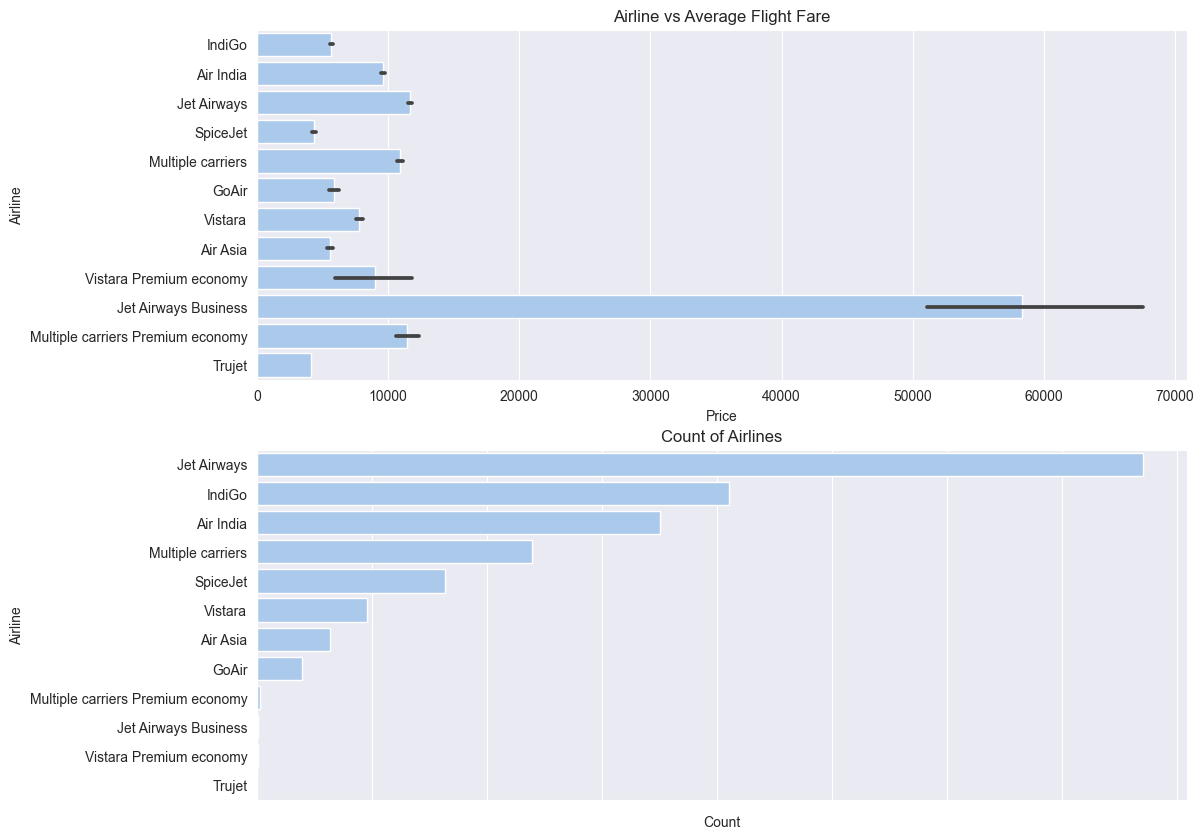

In [22]:
#plot a histogram for airlines to average flight fare

# Set the figure size
fig, axs = plt.subplots(2, figsize=(12, 10))

sns.set_color_codes("pastel")
sns.barplot(ax=axs[0], x=eda_df['Price'], y=eda_df['Airline'],
            label="Price", color="b")
axs[0].set_title("Airline vs Average Flight Fare")
#second plot
airline_counts = eda_df['Airline'].value_counts().reset_index(name='Count')
airline_counts.rename(columns={'index': 'Airline'}, inplace=True)
sns.barplot(ax=axs[1], data=airline_counts, x='Count', y='Airline', label='Airplanes Distribution', color="b")
axs[1].set_title("Count of Airlines")
# Rotate the x-axis labels for the second subplot
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha="right")

# Show the plot
plt.show()


#### Temporal Analysis
For a temporal analysis, we can focus on understanding how flight fares vary over time. Check for any seasonality or trends in flight fares over months or days of the week. 

Text(0.5, 1.0, 'Average Fare by Time of the Day')

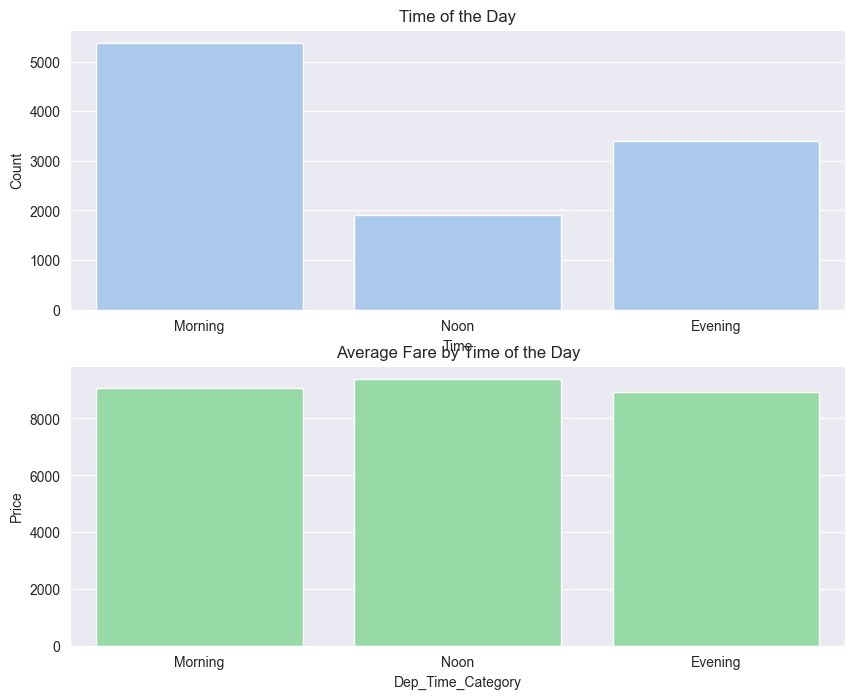

In [23]:
#Check count of Dep_Time_Category, and Dep_Time_Category against price total 
day_time = eda_df['Dep_Time_Category'].value_counts().reset_index(name='Count')
day_time.rename(columns={'index': 'Time'}, inplace=True)
day_price_sum=eda_df.groupby('Dep_Time_Category')['Price'].mean().reset_index()

fig, axs = plt.subplots(2, figsize=(10, 8))
#Plot First subplot
sns.set_color_codes("pastel")
sns.barplot(ax=axs[0], x=day_time['Time'], y=day_time['Count'], color="b")
axs[0].set_title("Time of the Day")
#Second Subplot
sns.set_color_codes("pastel")
sns.barplot(ax=axs[1], x=day_price_sum['Dep_Time_Category'], y=day_price_sum['Price'], color="g")
axs[1].set_title("Average Fare by Time of the Day")

Text(0.5, 1.0, 'Average Fare by Departure Hour')

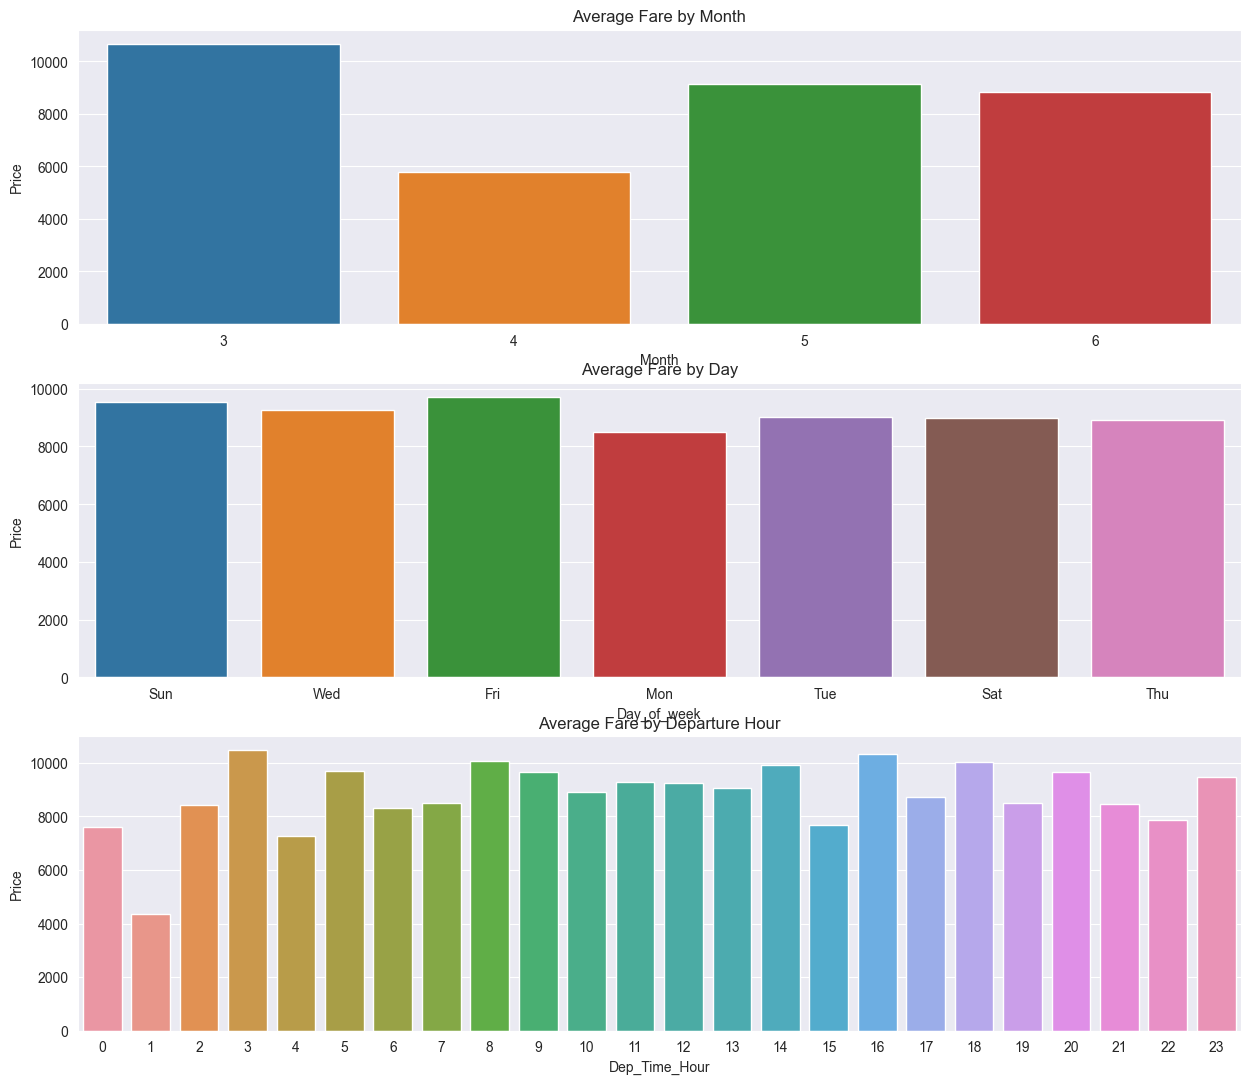

In [24]:
#Month, Day, and Time Analysis
fig, axs = plt.subplots(3, figsize=(15, 13))
sns.barplot(ax=axs[0], x='Month', y='Price', data=eda_df, errorbar=None)
axs[0].set_title("Average Fare by Month")
sns.barplot(ax=axs[1], x='Day_of_week', y='Price', data=eda_df, errorbar=None)
axs[1].set_title("Average Fare by Day")
sns.barplot(ax=axs[2], x='Dep_Time_Hour', y='Price', data=eda_df, errorbar=None)
axs[2].set_title("Average Fare by Departure Hour")

#### Bivariate Analysis: Correlation
Investigate the relationship between the target variable ('Price') and other numerical features using scatter plots or correlation matrices.

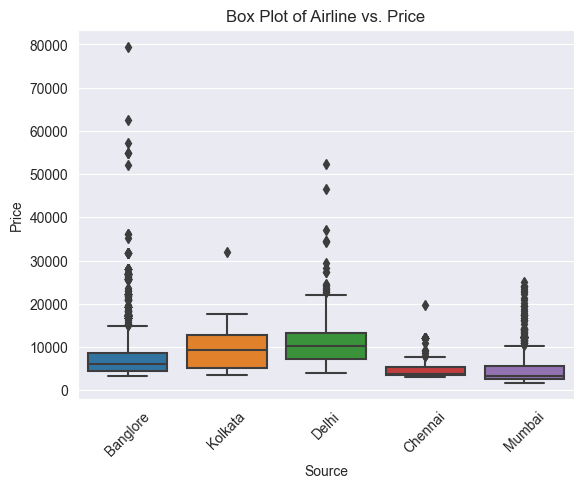

In [25]:
#Source-Price 
sns.boxplot(x='Source', y='Price', data=eda_df)
plt.title('Box Plot of Airline vs. Price')
plt.xticks(rotation=45)
plt.show()

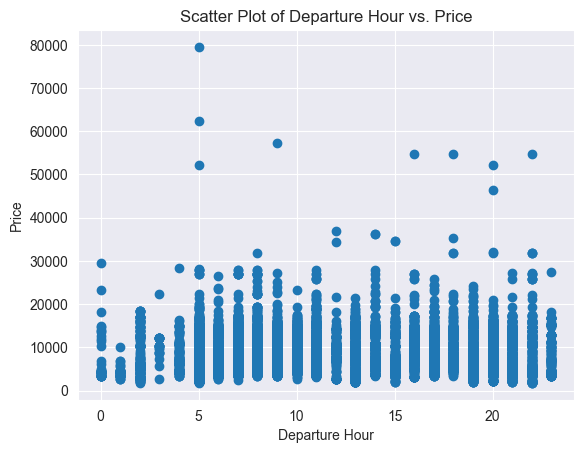

In [26]:
plt.scatter(eda_df['Dep_Time_Hour'], eda_df['Price'])
plt.title('Scatter Plot of Departure Hour vs. Price')
plt.xlabel('Departure Hour')
plt.ylabel('Price')
plt.show()

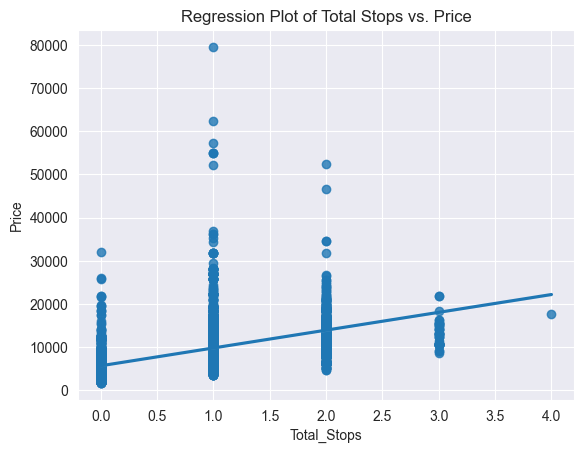

In [27]:
sns.regplot(x='Total_Stops', y='Price', data=eda_df)
plt.title('Regression Plot of Total Stops vs. Price')
plt.show()

/var/folders/tv/vq770p4964d1y3xfn8ln5m1h0000gn/T/ipykernel_40311/725770284.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr= eda_df.corr()


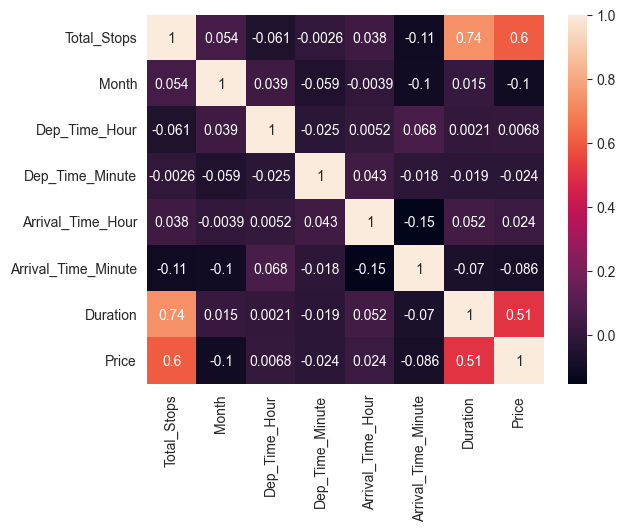

In [28]:
corr= eda_df.corr()
#corr = corr[['Total_Stops', 'Duration', 'Dep_Time_Hour', 'Dep_Time_Minute', 'Arrival_Time_Hour', 'Arrival_Time_Minute', 'Price']]
sns.heatmap(corr, annot=True)

In [29]:
corr.columns

Index(['Total_Stops', 'Month', 'Dep_Time_Hour', 'Dep_Time_Minute',
       'Arrival_Time_Hour', 'Arrival_Time_Minute', 'Duration', 'Price'],
      dtype='object')

#### Feature Engineering, One Hot Encoding and Feature Scaling

In [30]:
main_df['Total_Stops']=main_df['Total_Stops'].astype(float)
routes=main_df['Route'].unique()

# Extract individual stops and create binary columns for each stop
all_stops = set()
for route in routes:
    stops = route.split(' → ')
    all_stops.update(stops)

# Create binary columns for each stop
for stop in all_stops:
    main_df[f'Stop_{stop}'] = main_df['Route'].apply(lambda x: 1 if stop in x else 0).astype(float)

In [31]:
main_df.head(2)

,Airline,Source,Destination,Total_Stops,Booking_Class,Additional_Info,Date_of_Journey,Month,Day_of_week,Dep_Time_Category,...,Stop_UDR,Stop_JAI,Stop_ISK,Stop_IXR,Stop_IMF,Stop_GWL,Stop_PAT,Stop_IDR,Stop_HYD,Stop_BDQ
0,IndiGo,Banglore,New Delhi,0.0,Economy,No Info,2019-03-24,3,Sun,Evening,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Air India,Kolkata,Banglore,2.0,Economy,No Info,2019-05-01,5,Wed,Morning,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
one_hot_df=pd.get_dummies(main_df, columns=['Airline', 'Source', 'Destination', 'Booking_Class', 'Additional_Info', 'Month', 'Day_of_week', 'Dep_Time_Category', 'Dep_Time_Hour',
       'Arrival_Time_Hour'])
#drop columns that are not useful
one_hot_df=one_hot_df.drop(columns=['Date_of_Journey', 'Dep_Time', 'Route', 'Arrival_Time', 'Dep_Time_Minute', 'Arrival_Time_Minute'])
master_df=one_hot_df

In [33]:
#Split dataset to train and test
train_norm_df = master_df[master_df['Price'].notna()]
test_norm_df = master_df[master_df['Price'].isnull()]
print("Train dataset shape:", train_norm_df.shape)
print("Test dataset shape:", test_norm_df.shape)

Train dataset shape: (10682, 143)
Test dataset shape: (2671, 143)


In [34]:
#Feature Scaling for Price and duration
train_norm_df[['Duration','Price']].describe()

,Duration,Price
count,10682.000000,10682.000000
mean,643.020502,9087.214567
std,507.830133,4611.548810
min,5.000000,1759.000000
25%,170.000000,5277.000000
50%,520.000000,8372.000000
75%,930.000000,12373.000000
max,2860.000000,79512.000000


In [35]:
#Use Numpy log()
train_norm_df['Price'] = np.log1p(train_norm_df['Price'])

train_norm_df['Duration'] = np.log1p(train_norm_df['Duration'])
test_norm_df['Duration'] = np.log1p(test_norm_df['Duration'])

/var/folders/tv/vq770p4964d1y3xfn8ln5m1h0000gn/T/ipykernel_40311/2625746901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_norm_df['Price'] = np.log1p(train_norm_df['Price'])
/var/folders/tv/vq770p4964d1y3xfn8ln5m1h0000gn/T/ipykernel_40311/2625746901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_norm_df['Duration'] = np.log1p(train_norm_df['Duration'])
/var/folders/tv/vq770p4964d1y3xfn8ln5m1h0000gn/T/ipykernel_40311/2625746901.py:5: SettingWithCopyWarning: 
A value is trying to be set

#### Train Test Split

In [36]:
from sklearn.model_selection import train_test_split

#SPlit train dataset to train and train_test for training and evaluating the model
X = train_norm_df.drop(columns='Price')
y = train_norm_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)
print("Training data:", X_train.shape)
print("Training data:", X_test.shape)

Training data: (8011, 142)
Training data: (2671, 142)


#### Build Model

In [37]:
#Linear Regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Standardize the features (optional but often beneficial)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#initialize model and fit data
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)
#make predictions
predictions=lr.predict(X_test_scaled)
#Evaluate model
mae_lr = mean_absolute_error(y_test, predictions)
mse_lr = mean_squared_error(y_test, predictions)
r2_lr = r2_score(y_test, predictions)

print(f'Mean Absolute Error: {mae_lr:.2f}')
print(f'Mean Squared Error: {mse_lr:.2f}')
print(f'R-squared: {r2_lr:.2f}')

Mean Absolute Error: 1097070341.52
Mean Squared Error: 1118733183420059615232.00
R-squared: -4350916553092501078016.00


In [38]:
#Finding best parameter GridSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5]
}

grid_search = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


In [39]:
best_model

SVR(C=10)

In [40]:
#SVR 
svr_model = SVR(kernel='linear', C=10, epsilon=0.2)
svr_model.fit(X_train, y_train)
#Predict Model
y_pred = svr_model.predict(X_test)
#Evaluate model
mae_svr = mean_absolute_error(y_test, y_pred)
mse_svr = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae_svr}')
print(f'Mean Squared Error: {mse_svr}')

Mean Absolute Error: 0.16641551446473066
Mean Squared Error: 0.04973535480811301


In [61]:
#XGBoost REGRESSOR
from xgboost import XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=0)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model performance
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae_xgb}')
print(f'Mean Absolute Error: {mse_xgb}')


Mean Absolute Error: 0.10171893783178265
Mean Absolute Error: 0.027218152710315285


In [43]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()
param = {
    'alpha':[.0001, 0.001,0.01, 0.01,1]
       }

search = GridSearchCV(ridge_model, param, cv=5, scoring='neg_mean_absolute_error')
search.fit(X_train, y_train)

best_model = search.best_estimator_
best_model

Ridge(alpha=0.01)

In [44]:
#RIDGE REGRESSION

ridge_model = Ridge(alpha=0.01)  # You can adjust the regularization strength (alpha) as needed

# Fit the model on the training data
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model performance
mae_ridge = mean_absolute_error(y_test, y_pred)
mse_ridge = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae_ridge}')
print(f'Mean Absolute Error: {mse_ridge}')

Mean Absolute Error: 0.164648063258595
Mean Absolute Error: 0.0488965593336053


**XGB Booster** has the minimal error or has the highest accuracy score

#### Predict Test Dataset

In [47]:
#drop price column
x_test = test_norm_df.drop(labels='Price', axis=1)

In [62]:
#predict price using the trained xgb model
price_pred= xgb_model.predict(x_test)

In [77]:
#Convert to original value
price= np.expm1(price_pred)

In [69]:
test_df['Price']= price

In [71]:
predicted_test_df=test_df

In [72]:
 npredicted_test_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,14252.181641
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,4532.404785
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,12666.167969
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,10069.601562
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,3906.688965
...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,9675.448242
2667,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,4909.837891
2668,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,14690.061523
2669,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,9196.851562


In [76]:
writer = pd.ExcelWriter('Output.xlsx', engine='xlsxwriter')
predicted_test_df.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()

/var/folders/tv/vq770p4964d1y3xfn8ln5m1h0000gn/T/ipykernel_40311/232752003.py:3: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
